In [2]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np

import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
from tensiometer import utilities

def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-12-02 09:54:16.733805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Three moltivariate distributions

In [3]:
#Fixed Parameters
num_parameters = 2
num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')


# Anova-like stimators

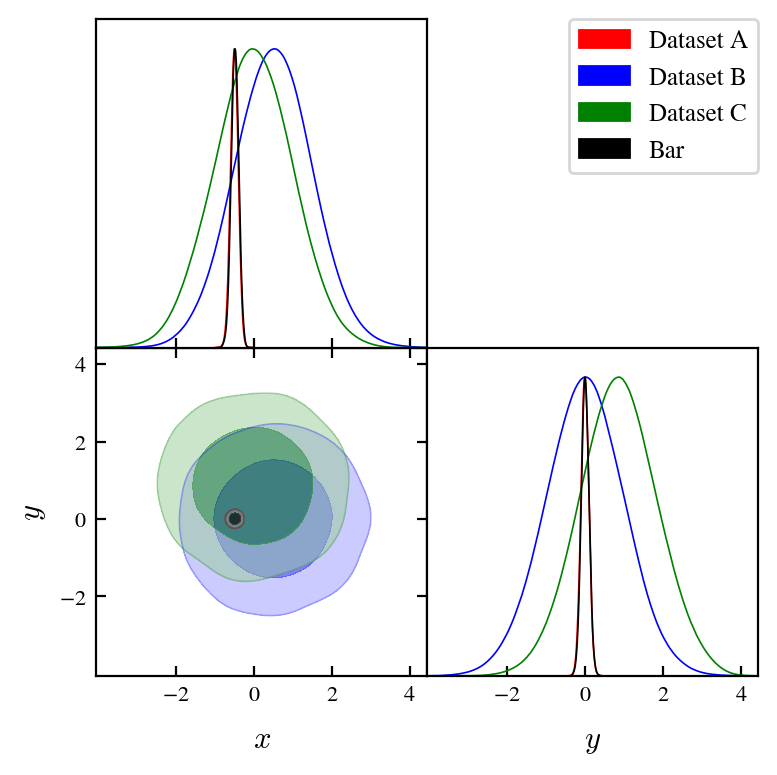

In [4]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance


delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

colors = ['red', 'blue', 'green', 'black']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_bar],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
plt.savefig('triangle_plot_3_centroid.pdf')

## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

In [5]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

print(r'alpha: {}'.format(alpha))


# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= alpha)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 > alpha].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))



alpha: 0.9661898121847512
[0.0098527  0.0098527  0.50239001 0.50239001 0.50239001 0.50239001]
(1000000, 6)
[[1.86369465e+00 2.85297216e-03 8.47243194e-01 4.85635515e+00
  1.59274276e+00 1.39232104e+00]
 [8.33440748e-01 1.34937877e+00 1.24814887e-01 2.75355822e-01
  2.74580798e+00 5.89542683e-02]
 [2.19255020e+00 2.51124910e-02 5.38931368e+00 1.39051811e-01
  5.54699063e-02 2.24573666e-02]
 ...
 [2.91055544e-04 1.93392390e+00 8.99454028e-01 4.83597884e-02
  3.39246055e-01 3.04954472e-01]
 [1.32538654e-02 2.43393632e-02 1.93735549e+00 1.36454598e+00
  1.57127890e+00 8.27082149e+00]
 [2.73980837e-01 1.47842236e-03 8.79299268e-01 5.85615361e-03
  5.00135359e-01 9.01876904e-01]]
PTE: 0.757336
n_sigma: 0.308981
PTE: 0.488938
n_sigma: 0.691999


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

In [6]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))


print(r'beta: {}'.format(beta))

df=num_datasets*num_parameters
PTE = chi2.sf(beta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > beta].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 2.48019801980198
PTE: 0.870677206683847
n_sigma: 0.162798
PTE: 0.87059083
n_sigma: 0.162908


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

In [7]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C))

print(r'gamma: {}'.format(gamma))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= gamma)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 >= gamma].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

gamma: 1.9705882352941178
[0.0098527  0.0098527  0.50239001 0.50239001 0.50239001 0.50239001]
(1000000, 6)
[[1.05197442e-01 4.23671803e-01 3.39897864e-01 2.69651389e-01
  1.54343954e+00 1.01983129e+00]
 [1.05265574e-07 3.93270237e-02 1.86486397e-01 1.08474360e-01
  2.06421320e-02 1.96991120e-02]
 [5.49853915e-03 1.69759560e+00 2.58078226e-01 8.86609827e-01
  3.17383023e-01 1.22466546e+00]
 ...
 [2.51590422e-02 7.74198431e-06 1.85342679e+00 4.56717960e-01
  1.50104242e-01 1.47419668e+00]
 [1.33396051e+00 6.46956473e-01 5.74594468e-01 1.78465787e+00
  3.46652389e-02 1.55226323e-02]
 [3.22024213e-04 2.99481031e+00 7.06094306e-01 9.31996121e-02
  8.49488444e-03 1.18088460e+00]]
PTE: 0.421618
n_sigma: 0.803617
PTE: 0.324069
n_sigma: 0.986131


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

In [8]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= delta)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''



PTE = samp_chi2[samp_chi2 > delta].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



[  2.02   2.02 103.   103.   103.   103.  ]
(1000000, 6)
[[7.87465686e-02 9.67169286e-01 2.60137123e-04 1.38113036e-01
  3.30787838e-02 9.29622434e-03]
 [4.69061906e-02 8.70340216e-01 6.43640900e-01 6.62183542e-04
  2.24048577e-02 2.62810944e-02]
 [1.14332056e-01 5.94574260e-02 2.24100952e-01 2.30141312e+00
  4.83359689e+00 3.65165049e-02]
 ...
 [1.84089472e-01 1.09903945e+01 2.68247564e-01 1.04539934e+00
  4.23039279e-01 2.91437492e-04]
 [2.35133776e+00 5.70124378e-01 1.61700347e+00 1.99361309e+00
  3.14760271e-02 3.44787280e-01]
 [2.97817815e+00 2.51138693e-01 3.64446943e-04 1.91681922e-01
  5.96346995e-03 4.22510203e-03]]
PTE: 0.75778
n_sigma: 0.308397
PTE: 0.490186
n_sigma: 0.690013


## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [9]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 1.9374614788720448
PTE: 0.9253594071790605
n_sigma: 0.093685
PTE: 0.92536189
n_sigma: 0.0936818


## $\zeta$-stimator

\begin{equation}
    \zeta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j) + \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [10]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))

beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))

zeta = beta + epsilon

print(r'beta: {}'.format(beta))
print(r'epsilon: {}'.format(epsilon))
print(r'zeta: {}'.format(zeta))

df=2*num_datasets*num_parameters
PTE = chi2.sf(zeta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 2.48019801980198
epsilon: 1.9374614788720448
zeta: 4.417659498674025
PTE: 0.9746677081712639
n_sigma: 0.0317547
